# RF Model Training, Quantization, and Parameters Export

## Environment & Imports

In [1]:
# Importing necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import copy 
import sys
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
from sklearn import tree
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score,balanced_accuracy_score
from imblearn import under_sampling, over_sampling
from imblearn.over_sampling import SMOTE
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')
import time


from pathlib import Path
import re
from typing import List

from __future__ import annotations


## Dataset Loading

In [2]:
#Dataset
data = pd.read_csv("allunsw_new_v2.csv")
#data = pd.read_csv("allunsw_new.csv")
data.head()

,pkSeqID,stime,flgs,proto,saddr,sport,daddr,dport,pkts,bytes,...,spkts,dpkts,sbytes,dbytes,rate,srate,drate,attack,category,subcategory
0,2399884,1528095766,e s,tcp,192.168.100.150,59030,192.168.100.3,80,6,736,...,5,1,676,60,0.438884,0.351107,0.0,1,DDoS,TCP
1,2634097,1528099322,e,udp,192.168.100.147,7420,192.168.100.3,80,14,840,...,14,0,840,0,0.838041,0.838041,0.0,1,DDoS,UDP
2,2624406,1528095781,e s,tcp,192.168.100.149,54607,192.168.100.3,80,5,582,...,4,1,522,60,0.137179,0.102884,0.0,1,DDoS,TCP
3,2861098,1528099326,e,udp,192.168.100.150,53853,192.168.100.3,80,6,360,...,6,0,360,0,0.465744,0.465744,0.0,1,DDoS,UDP
4,2813583,1528099324,e,udp,192.168.100.149,34757,192.168.100.3,80,6,360,...,6,0,360,0,0.421414,0.421414,0.0,1,DDoS,UDP


In [3]:
# General Information about the data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51130 entries, 0 to 51129
Data columns (total 29 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   pkSeqID      51130 non-null  int64  
 1   stime        51130 non-null  int64  
 2   flgs         51130 non-null  object 
 3   proto        51130 non-null  object 
 4   saddr        51130 non-null  object 
 5   sport        50650 non-null  object 
 6   daddr        51130 non-null  object 
 7   dport        50650 non-null  object 
 8   pkts         51130 non-null  int64  
 9   bytes        51130 non-null  int64  
 10  state        51130 non-null  object 
 11  ltime        51130 non-null  int64  
 12  seq          51130 non-null  int64  
 13  dur          51130 non-null  float64
 14  mean         51130 non-null  float64
 15  stddev       51130 non-null  float64
 16  sum          51130 non-null  float64
 17  min          51130 non-null  float64
 18  max          51130 non-null  float64
 19  spkt

In [4]:
target_features1 = data[['category']]
target_features2 = data[['attack']]
#all_features0 = data[['bytes','sbytes','spkts']]
all_features1 = data[['bytes','sbytes', 'dur']]
all_features2 = data[['pkts', 'bytes','dur','mean','stddev','sum','min','max','spkts','dpkts','sbytes','dbytes','rate','srate','drate']]
#all_features3 = data[['sum','sbytes','bytes']]

In [5]:
# Label Encoding the target columns
le = LabelEncoder()
target_features1= le.fit_transform(target_features1)

In [6]:
# Train-test Split
X_train, X_test, y_train, y_test = train_test_split(all_features1,target_features1, test_size = 0.34, random_state = 0)


In [7]:
#scaling the data to (0,65535) use for 16bit
min_max = MinMaxScaler(feature_range=(0,65535), copy=True)
X_train[X_train > 65535] = 65535
X_test[X_test > 65535] = 65535
X_train = min_max.fit_transform(X_train)
X_test = min_max.transform(X_test)

In [8]:
#scaling the data to (0,4095) use for 12bit
min_max = MinMaxScaler(feature_range=(0,4095), copy=True)
X_train[X_train > 4095] = 4095
X_test[X_test > 4095] = 4095
X_train = min_max.fit_transform(X_train)
X_test = min_max.transform(X_test)

In [9]:
data['category'].value_counts()

category
DDoS              20000
Reconnaissance    20000
Normal             9543
Theft              1587
Name: count, dtype: int64

In [10]:
data.groupby('category').count()

,pkSeqID,stime,flgs,proto,saddr,sport,daddr,dport,pkts,bytes,...,max,spkts,dpkts,sbytes,dbytes,rate,srate,drate,attack,subcategory
category,,,,,,,,,,,,,,,,,,,,,
DDoS,20000,20000,20000,20000,20000,20000,20000,20000,20000,20000,...,20000,20000,20000,20000,20000,20000,20000,20000,20000,20000
Normal,9543,9543,9543,9543,9543,9072,9543,9072,9543,9543,...,9543,9543,9543,9543,9543,9543,9543,9543,9543,9543
Reconnaissance,20000,20000,20000,20000,20000,20000,20000,20000,20000,20000,...,20000,20000,20000,20000,20000,20000,20000,20000,20000,20000
Theft,1587,1587,1587,1587,1587,1578,1587,1578,1587,1587,...,1587,1587,1587,1587,1587,1587,1587,1587,1587,1587


## Learning Curves & Hyperparameter Tuning: n_estimators and max_depth

Max Score：0.9749494504810743 Number of Trees：42


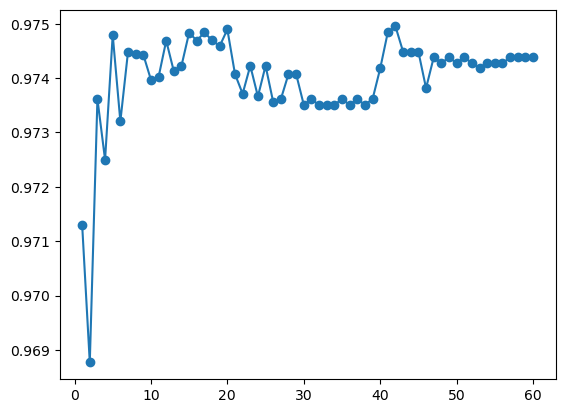

In [11]:
# tuning, draw learning rate to fine-tuning n_estimators
score_all = []

# Build a random forest every step
for i in range(0,60,1):
    rfc = RandomForestClassifier(oob_score=True,n_estimators=i+1, random_state=10,n_jobs = -1)
    rfc.fit(X_train, y_train)
    score_all.append(balanced_accuracy_score(y_test,rfc.predict(X_test), adjusted=True))
    #score_all.append(rfc.oob_score_)
score_max = max(score_all)
print('Max Score：{}'.format(score_max),
      'Number of Trees：{}'.format(score_all.index(score_max)*1+1))

# draw the curve
x = np.arange(1,61,1)
plt.subplot(111)
plt.plot(x, score_all, 'o-')
plt.show()

Max Score：0.9905763816861757 Number of Trees：52


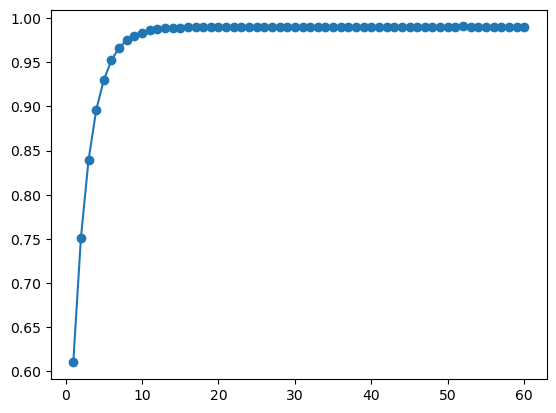

In [12]:
# tuning, draw learning rate to fine-tuning n_estimators
score_all = []

# Build a random forest every step
for i in range(0,60,1):
    rfc = RandomForestClassifier(oob_score=True,n_estimators=i+1, random_state=10,n_jobs = -1)
    rfc.fit(X_train, y_train)
    # score_all.append(balanced_accuracy_score(y_test,rfc.predict(X_test), adjusted=True))
    score_all.append(rfc.oob_score_)
score_max = max(score_all)
print('Max Score：{}'.format(score_max),
      'Number of Trees：{}'.format(score_all.index(score_max)*1+1))

# draw the curve
x = np.arange(1,61,1)
plt.subplot(111)
plt.plot(x, score_all, 'o-')
plt.show()

Max Score：0.9906816220880069 Number of Trees：15


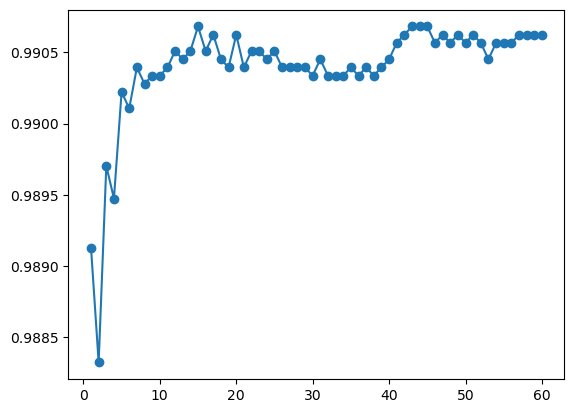

In [13]:
# tuning, draw learning rate to fine-tuning n_estimators
score_all = []

# Build a random forest every step
for i in range(0,60,1):
    rfc = RandomForestClassifier(oob_score=True,n_estimators=i+1, random_state=10,n_jobs = -1)
    rfc.fit(X_train, y_train)
    # score_all.append(balanced_accuracy_score(y_test,rfc.predict(X_test), adjusted=True))
    #score_all.append(rfc.oob_score_)
    score_all.append(accuracy_score(y_test,rfc.predict(X_test)))
score_max = max(score_all)
print('Max Score：{}'.format(score_max),
      'Number of Trees：{}'.format(score_all.index(score_max)*1+1))

# draw the curve
x = np.arange(1,61,1)
plt.subplot(111)
plt.plot(x, score_all, 'o-')
plt.show()

Max Score：0.9903940178314639 depth：11


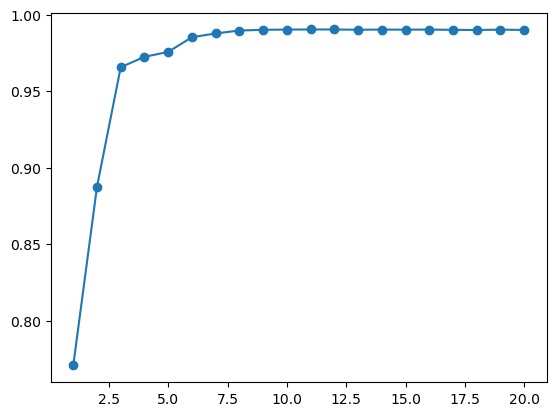

In [14]:
# tuning, draw learning rate to fine-tuning max_depth
score_lt4 = []
 
for i in range(0,20,1):
    rfc4 = RandomForestClassifier(oob_score=True,n_estimators=6, max_depth = i+1,random_state=10,n_jobs = -1)
    rfc4.fit(X_train, y_train)
    score_lt4.append(accuracy_score(y_test,rfc4.predict(X_test)))
    #score_lt4.append(rfc4.oob_score_)
score_max4 = max(score_lt4)
print('Max Score：{}'.format(score_max4),
      'depth：{}'.format(score_lt4.index(score_max4)*1+1))

x = np.arange(1,21,1)
plt.subplot(111)
plt.plot(x, score_lt4, 'o-')
plt.show()

oob_score只受到树的数量，最大深度等树的参数影响，当参数确定，该值确定，因而不能用于量化后模型的性能评估

oob_score is only affected by the number of trees, maximum depth and other tree parameters. Once the parameters are determined, the value is determined, so it cannot be used to evaluate the performance of the quantized model.

## Model Training & Evaluation

In [15]:
rf1=RandomForestClassifier(oob_score=True,n_estimators = 6,max_depth=11,random_state=10,n_jobs = -1) # 6 trees, 11 max_depth
rf1.fit(X_train, y_train)

RandomForestClassifier(max_depth=11, n_estimators=6, n_jobs=-1, oob_score=True,
                       random_state=10)

In [16]:
print(classification_report(y_test,rf1.predict(X_test),digits=6))

              precision    recall  f1-score   support

           0   0.999854  1.000000  0.999927      6832
           1   0.992595  0.957751  0.974862      3219
           2   0.980346  0.998517  0.989348      6744
           3   0.986135  0.964407  0.975150       590

    accuracy                       0.990394     17385
   macro avg   0.989733  0.980169  0.984822     17385
weighted avg   0.990477  0.990394  0.990341     17385



## Post-Training Quantization

In [17]:
for i in range(6):
    print(np.max(rf1.estimators_[i].tree_.threshold))

4048.331787109375
4087.3192138671875
4037.7755126953125
4048.2822265625
4048.2822265625
4048.331787109375


In [18]:
# Quantization Utilities (option: develop more advanced quantization techniques)

#The quantization mapping of a floating point value x (value between 0.0001 and 65534.5997) to  
#a 16 bit integer (value between 0 and 65535).65534.658203125  
def quantize_16(x):
    return clip(int((round((1 / (65475.46093 / 65535)) * x) + round(((65534.59001 * 0) - (0.00001 * 65535)) / 65475.46093))), 0, 65535)
#0.001 4089.419 4076.224853515625
def quantize_12(x):
    return clip(int((round((1 / (4087.3192138671875 / 4095)) * x) + round(((4087.3192138671876 * 0) - (0.000000000001 * 4095)) / 4087.3192138671875))), 0, 4095)
def clip(rounded, minimum, maximum):
    if(rounded < minimum): return minimum
    elif(minimum <= rounded and rounded <= maximum): return rounded
    else: return maximum

In [19]:
def quantizeTrees():
    for i in range(0,6):
        for x in range(0,len(rf1.estimators_[i].tree_.threshold)):
            rf1.estimators_[i].tree_.threshold[x] = quantize_12(rf1.estimators_[i].tree_.threshold[x])  

quantizeTrees()

In [20]:
for x in X_test:
    for i in range(0,len(x)):
        x[i] = quantize_12(x[i]) 

In [21]:
print(classification_report(y_test,rf1.predict(X_test),digits=6))

              precision    recall  f1-score   support

           0   0.999854  1.000000  0.999927      6832
           1   0.965441  0.945946  0.955594      3219
           2   0.971821  0.986951  0.979328      6744
           3   0.983607  0.915254  0.948200       590

    accuracy                       0.982053     17385
   macro avg   0.980180  0.962038  0.970762     17385
weighted avg   0.982056  0.982053  0.981972     17385



In [22]:
print(confusion_matrix(y_test,rf1.predict(X_test)))

[[6832    0    0    0]
 [   1 3045  168    5]
 [   0   84 6656    4]
 [   0   25   25  540]]


In [23]:
print(balanced_accuracy_score(y_test,rf1.predict(X_test), adjusted=True))

0.9493838491365484


In [24]:
print(accuracy_score(y_test,rf1.predict(X_test)))

0.982053494391717


In [25]:
for i in range(6):
    print(np.max(rf1.estimators_[i].tree_.threshold))

4056.0
4095.0
4045.0
4056.0
4056.0
4056.0


In [26]:
for i in range(6):
    print(rf1.estimators_[i].tree_.node_count)

311
369
305
347
303
273


## Export Random Forest Text: random-forest.txt (tree-separated with x)

In [27]:
"""
RandomForest 导出器
- 提取每棵树的 threshold/feature/children/value
- 计算每个节点的类别
- 将每个节点序列化为比特拼接的一行文本
- 树末尾写入一行 'x'
"""

"""
RandomForest Exporter
- Extracts the threshold/feature/children/value of each tree
- Calculates the class of each node
- Serializes each node into a bit-concatenated line of text
- Writes a line with 'x' at the end of the tree
"""

def _encode_bits(x: int, width: int) -> str:
    # 将整数 x 编码为固定宽度的二进制字符串（不截断，只做零填充）Encode the integer x as a fixed-width binary string (no truncation, just zero-padding)
    b = bin(int(x)).replace("0b", "")
    # 反转-补零-再反转 Reverse - fill with zeros - reverse again
    y = b[::-1]
    while len(y) < width:
        y += "0"
    return y[::-1]


def _encode_w12(x: int) -> str:
    # -2 => all 1（4095），-1 => 0
    if x == -2:
        x = 4095
    elif x == -1:
        x = 0
    return _encode_bits(x, 12)


def _encode_w4(x: int) -> str:
    if x == -2:
        x = 15
    elif x == -1:
        x = 0
    return _encode_bits(x, 4)


def _encode_w9(x: int) -> str:
    if x == -2:
        x = 511
    elif x == -1:
        x = 0
    return _encode_bits(x, 9)


def _encode_w2(x: int) -> str:
    # -2 -> 4
    if x == -2:
        x = 4
    elif x == -1:
        x = 0
    return _encode_bits(x, 2)

def _encode_w16(x: int) -> str:
    if x == -2:
        x = 65535
    elif x == -1:
        x = 0
    return _encode_bits(x, 16)


def _encode_w8(x: int) -> str:
    if x == -2:
        x = 255
    elif x == -1:
        x = 0
    return _encode_bits(x, 8)

In [28]:
def _node_class(value_vec: np.ndarray) -> int:
    # 给定一个节点的 value（形状通常为 [1, n_classes] 或 [n_outputs, n_classes]），返回该节点的类别索引（出现次数最多的类别）。
    # Given a node value (usually of shape [1, n_classes] or [n_outputs, n_classes]), return the class index of the node (the class with the most occurrences).
    arr = np.asarray(value_vec).reshape(-1)
    return int(arr.argmax())


def _classes_per_tree(values: np.ndarray) -> np.ndarray:
    #对某棵树的所有节点 value（形状 [node_count, n_outputs, n_classes]）计算类别数组。
    #Calculate the category array for all node values ​​(shape [node_count, n_outputs, n_classes]) of a tree.
    return np.array([_node_class(v) for v in values], dtype=int)

In [29]:
def _serialize_node(thresholds, features, lefts, rights, classes, nid: int) -> str:
    # Serialize a single node into a concatenated binary string： 12b(threshold) + 4b(feature) + 9b(left) + 9b(right) + 2b(class)
    # threshold rounding
    t12 = _encode_w12(int(thresholds[nid]))
    f4  = _encode_w4(int(features[nid]))
    l9  = _encode_w9(int(lefts[nid]))
    r9  = _encode_w9(int(rights[nid]))
    c2  = _encode_w2(int(classes[nid]))
    return f"{t12}{f4}{l9}{r9}{c2}"

In [30]:
def dump_forest_as_text(rf, n_trees: int, out_path: str = "random-forest.txt") -> None:
    # 将前 n_trees 棵基学习器导出到文本文件
    # 收集基学习器（决策树）
    # Export the first n_trees base learners to a text file
    # Collect base learners (decision trees)
    trees = list(rf.estimators_[:n_trees])

    lines = []
    for tree in trees:
        tr = tree.tree_
        thr = tr.threshold           # float32
        feat = tr.feature            # int32（-2 -> leaf）
        left = tr.children_left      # int32（-1 -> no child）
        right = tr.children_right    # int32
        vals = tr.value              # [node_count, n_outputs, n_classes]

        # class per node
        cls = _classes_per_tree(vals)

        # Node-by-node serialization
        for nid in range(tr.node_count):
            lines.append(_serialize_node(thr, feat, left, right, cls, nid))

        # append x per tree
        lines.append("x")
    

    # write txt
    with open(out_path, "w", encoding="utf-8") as f:
        f.write("\n".join(lines))


In [31]:
def writeNodeData(rf_model, out_txt: str = "random-forest.txt", n_estimators: int = 6) -> None:
    # export rf_model first n_estimators to out_txt
    dump_forest_as_text(rf_model, n_estimators, out_txt)

In [32]:
writeNodeData(rf1, out_txt="random-forest.txt", n_estimators=6)

## Export Vivado Artifacts: .coe (no x) & rf_bases.vh (BASE addresses)

In [33]:
def load_forest_txt(path: str) -> List[List[str]]:
    # Read txt and divide it into multiple trees by 'x'; each tree is a list containing 36-bit binary lines
    trees: List[List[str]] = [[]]
    for raw in Path(path).read_text(encoding="utf-8").splitlines():
        line = raw.strip()
        if not line:
            continue
        if line.lower() == "x":
            if trees[-1]:          # 
                trees.append([])
            continue
        if not BITLINE_RE.match(line):
            raise ValueError(f"find line which is not 36bit：{line[:60]}")
        trees[-1].append(line)
    if trees and not trees[-1]:      # 
        trees.pop()
    if not trees:
        raise ValueError("read no trees，please check txt")
    return trees

def write_coe(lines: List[str], out_path: str, radix: int = 2):
    # write Vivado COE（radix=2）
    if radix != 2:
        raise ValueError("仅支持 radix=2")
    header = [
        f"memory_initialization_radix={radix};",
        "memory_initialization_vector="
    ]
    body = [ (ln + ("," if i < len(lines)-1 else ";")) for i, ln in enumerate(lines) ]
    Path(out_path).write_text("\n".join(header + body) + "\n", encoding="utf-8")

def write_coe_per_tree(trees: List[List[str]], out_dir: str, prefix: str = "rf_tree"):
    outp = Path(out_dir)
    outp.mkdir(parents=True, exist_ok=True)
    for i, t in enumerate(trees):
        write_coe(t, str(outp / f"{prefix}{i}.coe"), radix=2)

def compute_bases_by_len(lengths: List[int], gap: int = 0) -> List[int]:
    # calculate bases：base[0]=0, base[i]=base[i-1]+len[i-1]+gap
    bases = []
    cur = 0
    for L in lengths:
        bases.append(cur)
        cur += L + gap
    return bases

def gen_header_vh(bases: List[int], out_path: str, macro_prefix: str = "RF", node_width_bits: int = 36):
    lines = []
    lines.append(f"`ifndef {macro_prefix}_ADDRS_VH")
    lines.append(f"`define {macro_prefix}_ADDRS_VH\n")
    lines.append(f"`define {macro_prefix}_NUM_TREES {len(bases)}")
    lines.append(f"`define {macro_prefix}_NODE_WIDTH {node_width_bits}\n")
    for i, b in enumerate(bases):
        lines.append(f"localparam integer BASE{i} = {b};")
    lines.append("\n`endif // " + f"{macro_prefix}_ADDRS_VH" + "\n")
    Path(out_path).write_text("\n".join(lines), encoding="utf-8")

In [34]:
TXT_PATH = "random-forest.txt"          # txt file
OUT_COE_ALL = "random-forest_all.coe"   # rf coe
OUT_COE_DIR = "per_tree_coe"            # dir for per tree coe
OUT_VH = "rf_bases.vh"                  # vh file
ALSO_EACH_TREE = True                 # whether export per tree coe
GAP = 0                                 # gap between trees

# set USE_FIXED_BASES=True, to use fixed bases
USE_FIXED_BASES = False
FIXED_BASES = [0, 306, 658, 948, 1304, 1612]  # example：print(rf1.estimators_[i].tree_.node_count) 
BITLINE_RE = re.compile(r"^[01]{36}$")  # 36bit

In [35]:
trees = load_forest_txt(TXT_PATH)
lengths = [len(t) for t in trees]
print(f"[INFO] read {len(trees)} tree，node number：{lengths}（remove 'x'）")

# export coe（no 'x'）
all_lines = [ln for t in trees for ln in t]
write_coe(all_lines, OUT_COE_ALL, radix=2)
print(f"[OK] write RF COE：{OUT_COE_ALL}（{len(all_lines)} 行）")

# per tree coe
if ALSO_EACH_TREE:
    write_coe_per_tree(trees, OUT_COE_DIR, prefix="rf_tree")
    print(f"[OK] write per tree COE to：{OUT_COE_DIR}")

# head base calculation（start address of each tree）
if USE_FIXED_BASES:
    if len(FIXED_BASES) != len(trees):
        raise ValueError("FIXED_BASES length different from number of trees")
    bases = FIXED_BASES
    print("[INFO] use fixed BASE：", bases)
else:
    bases = compute_bases_by_len(lengths, gap=GAP)
    print(f"[INFO] auto calculate BASE（gap={GAP}）：", bases)

gen_header_vh(bases, OUT_VH, macro_prefix="RF", node_width_bits=36)
print(f"[OK] write header：{OUT_VH}")

# Preview
print("\n[PREVIEW] COE 5 lines：")
for ln in all_lines[:5]:
    print("  ", ln)
print("  ...")

print("\n[PREVIEW] Verilog Header：")
print(Path(OUT_VH).read_text(encoding="utf-8"))

[INFO] read 6 tree，node number：[311, 369, 305, 347, 303, 273]（remove 'x'）
[OK] write RF COE：random-forest_all.coe（1908 行）
[OK] write per tree COE to：per_tree_coe
[INFO] auto calculate BASE（gap=0）： [0, 311, 680, 985, 1332, 1635]
[OK] write header：rf_bases.vh

[PREVIEW] COE 5 lines：
   000000011111000100000000100101011000
   000010001110000000000001000101010110
   000000001001000100000001100000010010
   000000000000111100000000000000000001
   000000000000001000000010100011101010
  ...

[PREVIEW] Verilog Header：
`ifndef RF_ADDRS_VH
`define RF_ADDRS_VH

`define RF_NUM_TREES 6
`define RF_NODE_WIDTH 36

localparam integer BASE0 = 0;
localparam integer BASE1 = 311;
localparam integer BASE2 = 680;
localparam integer BASE3 = 985;
localparam integer BASE4 = 1332;
localparam integer BASE5 = 1635;

`endif // RF_ADDRS_VH

